# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

/home/leopoldh/Documents/KTH/mlfs-book/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 20, 14, 51, 45, 154274)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
try:
    with open('../../.venv/.secret/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
except:
    pass
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1180820
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.644606E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today - datetime.timedelta(1)).read()
batch_data

Finished: Reading data from Hopsworks, using Hive (1.64s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling
0,2024-11-20,4.00,0.1,15.124284,268.636100,lucerne,1.093333
1,2024-11-21,2.75,0.0,8.891343,58.240574,lucerne,0.626667


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_rolling"]])
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling,predicted_pm25
0,2024-11-20,4.00,0.1,15.124284,268.636100,lucerne,1.093333,0.747535
1,2024-11-21,2.75,0.0,8.891343,58.240574,lucerne,0.626667,1.068206


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         2 non-null      datetime64[ns]
 1   temperature_2m_mean          2 non-null      float64       
 2   precipitation_sum            2 non-null      float64       
 3   wind_speed_10m_max           2 non-null      float64       
 4   wind_direction_10m_dominant  2 non-null      float64       
 5   city                         2 non-null      object        
 6   pm25_rolling                 2 non-null      float64       
 7   predicted_pm25               2 non-null      float32       
dtypes: datetime64[ns](1), float32(1), float64(5), object(1)
memory usage: 252.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20,4.00,0.1,15.124284,268.636100,lucerne,1.093333,0.747535,adligenswilerstrasse,switzerland,1
1,2024-11-21,2.75,0.0,8.891343,58.240574,lucerne,0.626667,1.068206,adligenswilerstrasse,switzerland,2


In [20]:
# change collumns to 'float32'
batch_data['temperature_2m_mean'] = batch_data['temperature_2m_mean'].astype('float32')
batch_data['precipitation_sum'] = batch_data['precipitation_sum'].astype('float32')
batch_data['wind_speed_10m_max'] = batch_data['wind_speed_10m_max'].astype('float32')
batch_data['wind_direction_10m_dominant'] = batch_data['wind_direction_10m_dominant'].astype('float32')
batch_data['pm25_rolling'] = batch_data['pm25_rolling'].astype('float64')
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype('float32')


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

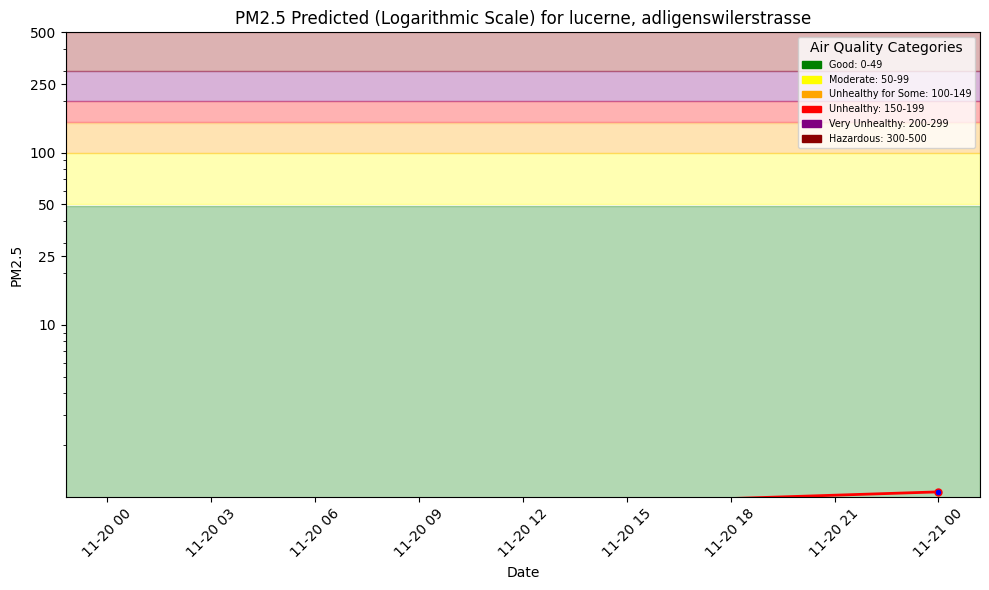

In [17]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [18]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [21]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 2/2 | Elapsed Time: 00:10 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1180820/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x77d2c8bbb680>, None)

In [22]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hive (1.71s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20,4.000000,0.1,15.124284,268.636100,lucerne,1.093333,0.747535,adligenswilerstrasse,switzerland,1
1,2024-11-15,3.269167,0.0,3.710795,293.983430,lucerne,1.990000,4.113874,adligenswilerstrasse,switzerland,1
2,2024-11-10,7.227500,0.0,3.710795,349.464780,lucerne,3.416667,6.646133,adligenswilerstrasse,switzerland,1
3,2024-11-12,6.335834,3.4,12.744457,35.100520,lucerne,3.133333,2.128591,adligenswilerstrasse,switzerland,1
4,2024-11-17,5.333750,0.4,7.100310,27.216135,lucerne,2.396667,2.183602,adligenswilerstrasse,switzerland,1
5,2024-11-19,9.200000,0.1,14.982228,215.217680,lucerne,1.926667,2.108039,adligenswilerstrasse,switzerland,1
6,2024-11-13,4.737916,1.2,7.596341,19.584793,lucerne,2.360000,2.887985,adligenswilerstrasse,switzerland,1
7,2024-11-14,4.065000,0.0,6.112053,355.924770,lucerne,2.233333,4.112766,adligenswilerstrasse,switzerland,1
8,2024-11-11,7.452501,6.7,8.019601,345.304750,lucerne,3.383333,2.033866,adligenswilerstrasse,switzerland,1
9,2024-11-16,3.840000,0.0,4.044997,330.107600,lucerne,2.403333,4.106001,adligenswilerstrasse,switzerland,1


In [23]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hive (2.83s) 


,date,pm25,country,city,street,url
0,2020-01-10,3.15,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1,2021-06-17,3.13,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
2,2024-07-02,1.10,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
3,2021-05-25,0.45,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
4,2021-05-09,1.00,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
...,...,...,...,...,...,...
1786,2022-07-03,1.48,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1787,2019-12-10,1.84,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1788,2023-01-16,0.40,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070
1789,2024-11-19,0.00,switzerland,lucerne,adligenswilerstrasse,https://api.waqi.info/feed/A75070


In [24]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
2,2024-11-10,6.646133,2.90
8,2024-11-11,2.033866,2.95
3,2024-11-12,2.128591,1.23
6,2024-11-13,2.887985,2.52
7,2024-11-14,4.112766,2.22
1,2024-11-15,4.113874,2.47
9,2024-11-16,4.106001,2.50
4,2024-11-17,2.183602,2.40
5,2024-11-19,2.108039,0.00
0,2024-11-20,0.747535,1.00


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

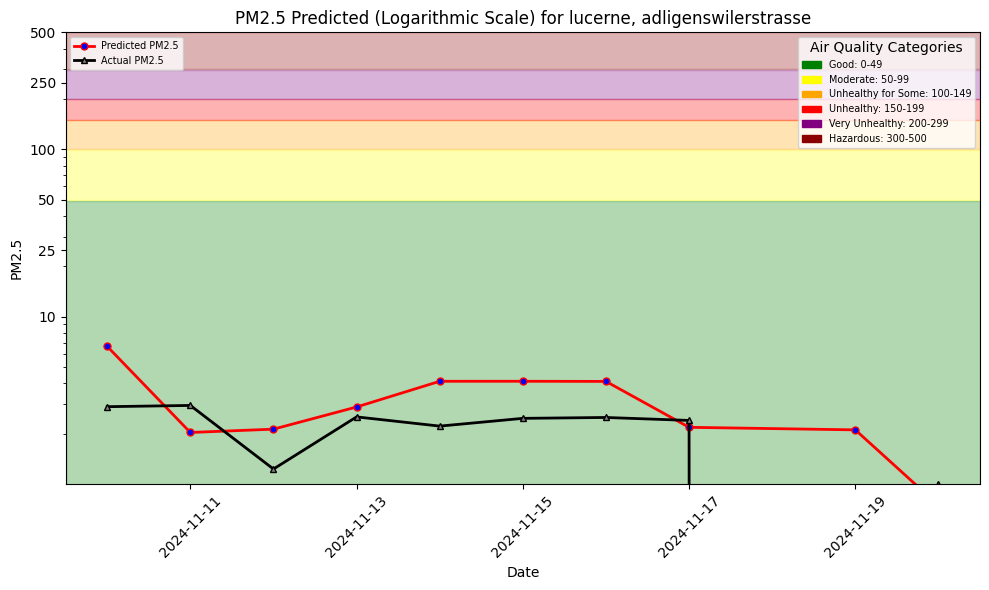

In [25]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---